# 📘 XRPlace: Распознавание дверей, окон и назначения помещений на плане


## 📌 Цель проекта

Компания **XRPlace** разрабатывает интерактивные 3D-модели квартир и домов, которые можно осматривать в браузере от первого лица.  
Для автоматизации создания 3D-сцен необходимо автоматически определять **дверные и оконные проёмы**, а также, по возможности, **назначение помещений** по изображениям архитектурных планов.

---

## 🧠 Задачи проекта

- Исследование открытых датасетов планов помещений.
- Выбор предобученной модели и типа задачи:
  - Object Detection / Segmentation — для дверей и окон,
  - Classification — для типа помещения.
- Обучение модели на открытых данных.
- Постпроцессинг: преобразование масок/bbox в координаты.
- Тестирование на пользовательских данных.
- Разработка интерактивного Gradio-приложения.
- Анализ ошибок модели и улучшение.

---

## 🛠️ Используемый стек

- **YOLOv11** + **PyTorch** — детекция и сегментация.
- **Roboflow API** — загрузка датасетов.
- **OpenCV**, **Pillow**, **NumPy** — обработка изображений.
- **matplotlib**, **seaborn** — визуализация.
- **Gradio** — демо-интерфейс.
- Метрики: **IoU**, **mAP**.

---

## Содержание

**1. Получение и анализ данных**

**2. Выбор модели**

**3. Обучение**

**4. Постпроцессинг**

**5. Анализ ошибок**

**6. Gradio-приложение**

**7. Результаты**

---


In [1]:
!pip install albumentations opencv-python tqdm -q

In [2]:
!pip install ultralytics  -q

In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image, ImageDraw
import yaml
from ultralytics import YOLO
import importlib 
import my_func
from my_func import *
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
try:
    importlib.reload(my_func)
except: 
    print('my_func не обновлено.')
    pass


# Загрузка датасета

In [19]:
door = eda_df("../data/door_yolo11")

Кол-во изображений: 113
Кол-во файлов аннотаций: 113
---
       width  height
count  113.0   113.0
mean   640.0   640.0
std      0.0     0.0
min    640.0   640.0
25%    640.0   640.0
50%    640.0   640.0
75%    640.0   640.0
max    640.0   640.0
---

Распределение объектов по классам:

Класс 0: 372 объектов
---
Классы: ['door']


In [4]:
ds_2 = eda_df("../data/ds_2")

Кол-во изображений: 590
Кол-во файлов аннотаций: 590
---
             width       height
count   590.000000   590.000000
mean    880.069492   801.316949
std     484.026357   365.090787
min     173.000000   278.000000
25%     543.000000   539.000000
50%     747.000000   711.000000
75%    1057.000000   923.000000
max    2048.000000  2048.000000
---

Распределение объектов по классам:

Класс 0: 5154 объектов
Класс 1: 3790 объектов
---
Классы: ['door', 'window']


In [20]:
train_img_dir, train_lbl_dir, class_names = door[0]

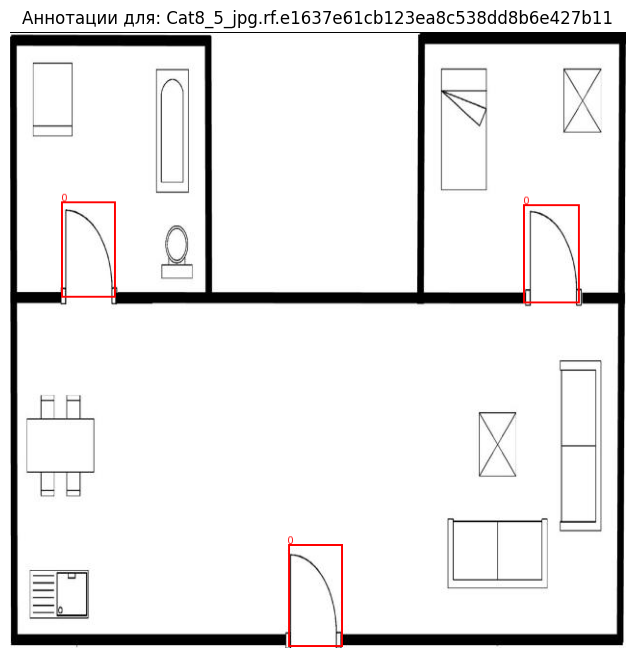

In [21]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 100)

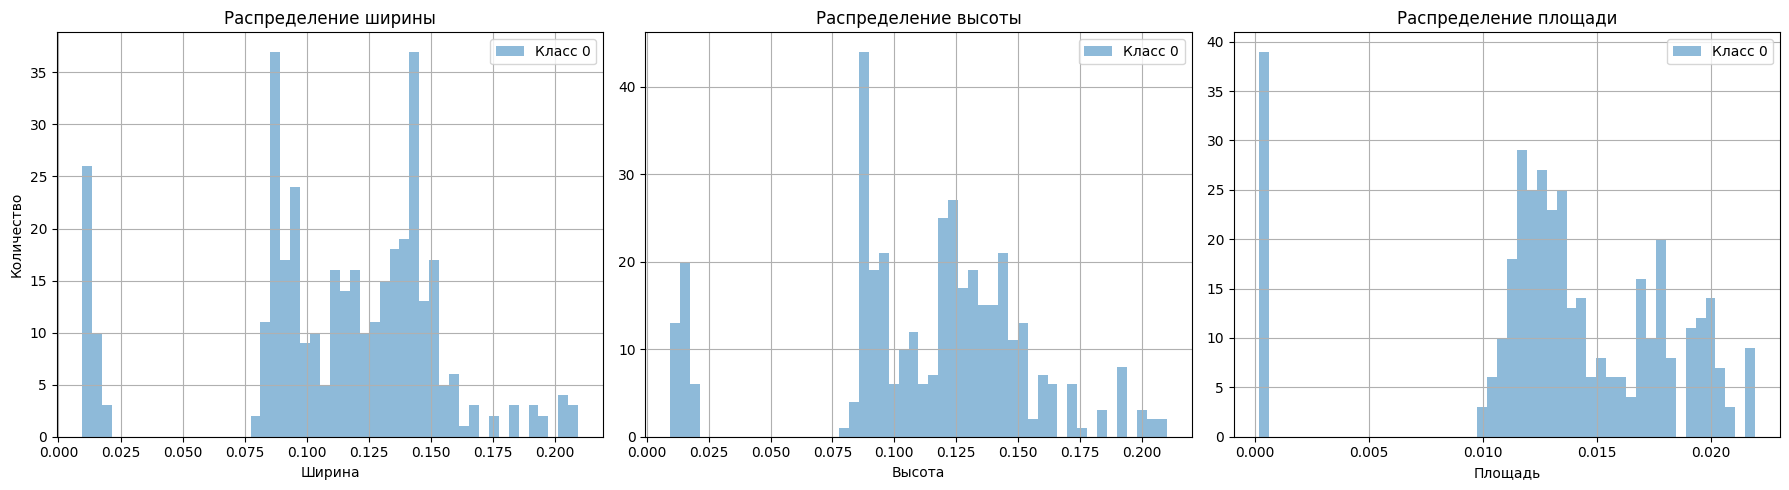

In [23]:
# Структура: {class_id: {'widths': [], 'heights': [], 'areas': []}}
box_stats = {}

# Чтение всех файлов
for filename in os.listdir(train_lbl_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(train_lbl_dir, filename), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, _, _, w, h = parts
                class_id = int(class_id)
                w = float(w)
                h = float(h)
                area = w * h

                if class_id not in box_stats:
                    box_stats[class_id] = {'widths': [], 'heights': [], 'areas': []}
                
                box_stats[class_id]['widths'].append(w)
                box_stats[class_id]['heights'].append(h)
                box_stats[class_id]['areas'].append(area)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
bins = 50

# Гистограммы по ширине, высоте и площади
for class_id, stats in box_stats.items():
    axes[0].hist(stats['widths'], bins=bins, alpha=0.5, label=f'Класс {class_id}')
    axes[1].hist(stats['heights'], bins=bins, alpha=0.5, label=f'Класс {class_id}')
    axes[2].hist(stats['areas'], bins=bins, alpha=0.5, label=f'Класс {class_id}')

# Подписи и оформление
axes[0].set_title("Распределение ширины")
axes[0].set_xlabel("Ширина")
axes[0].set_ylabel("Количество")

axes[1].set_title("Распределение высоты")
axes[1].set_xlabel("Высота")

axes[2].set_title("Распределение площади")
axes[2].set_xlabel("Площадь")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


# Аугментация

In [8]:
'''
# Пути
INPUT_IMAGES_DIR = '../data/ds_2/train/images'
INPUT_LABELS_DIR = '../data/ds_2/train/labels'
OUTPUT_IMAGES_DIR = '../data/ds_2/train/images'
OUTPUT_LABELS_DIR = '../data/ds_2/train/labels'

os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)

# Аугментации
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.Blur(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.5),
    A.CLAHE(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Процессинг
for image_file in tqdm(os.listdir(INPUT_IMAGES_DIR)):
    if not image_file.endswith(('.jpg', '.png', '.jpeg')):
        continue

    # Загрузка изображения
    image_path = os.path.join(INPUT_IMAGES_DIR, image_file)
    label_path = os.path.join(INPUT_LABELS_DIR, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Загрузка аннотаций
    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, w, h = map(float, line.strip().split())
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))
    else:
        continue

    # Применение трансформации
    for i in range(3):  # 3 аугментированные копии
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        # Сохранение
        aug_img_name = image_file.replace('.jpg', f'_aug{i}.jpg').replace('.png', f'_aug{i}.jpg')
        aug_label_name = aug_img_name.replace('.jpg', '.txt')

        cv2.imwrite(os.path.join(OUTPUT_IMAGES_DIR, aug_img_name), aug_image)

        with open(os.path.join(OUTPUT_LABELS_DIR, aug_label_name), 'w') as f:
            for cls, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{int(cls)} {' '.join(f'{v:.6f}' for v in bbox)}\n")
                
'''

100%|██████████| 591/591 [00:23<00:00, 25.67it/s]


In [9]:
ds_2 = eda_df("../data/ds_2")

Кол-во изображений: 2360
Кол-во файлов аннотаций: 2360
---
             width       height
count  2360.000000  2360.000000
mean    880.351271   801.963559
std     485.131678   367.595149
min     159.000000   271.000000
25%     543.000000   539.000000
50%     746.000000   711.000000
75%    1057.000000   923.250000
max    2251.000000  2242.000000
---

Распределение объектов по классам:

Класс 0: 20611 объектов
Класс 1: 15132 объектов
---
Классы: ['door', 'window']


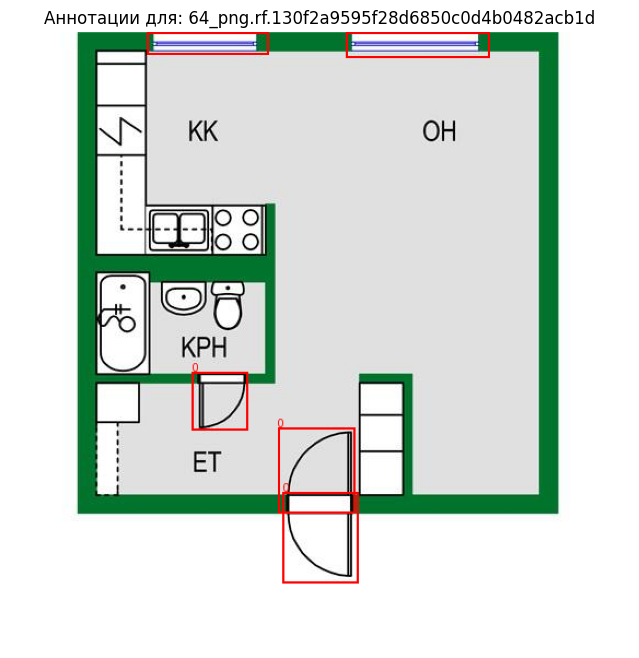

In [10]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 2000)

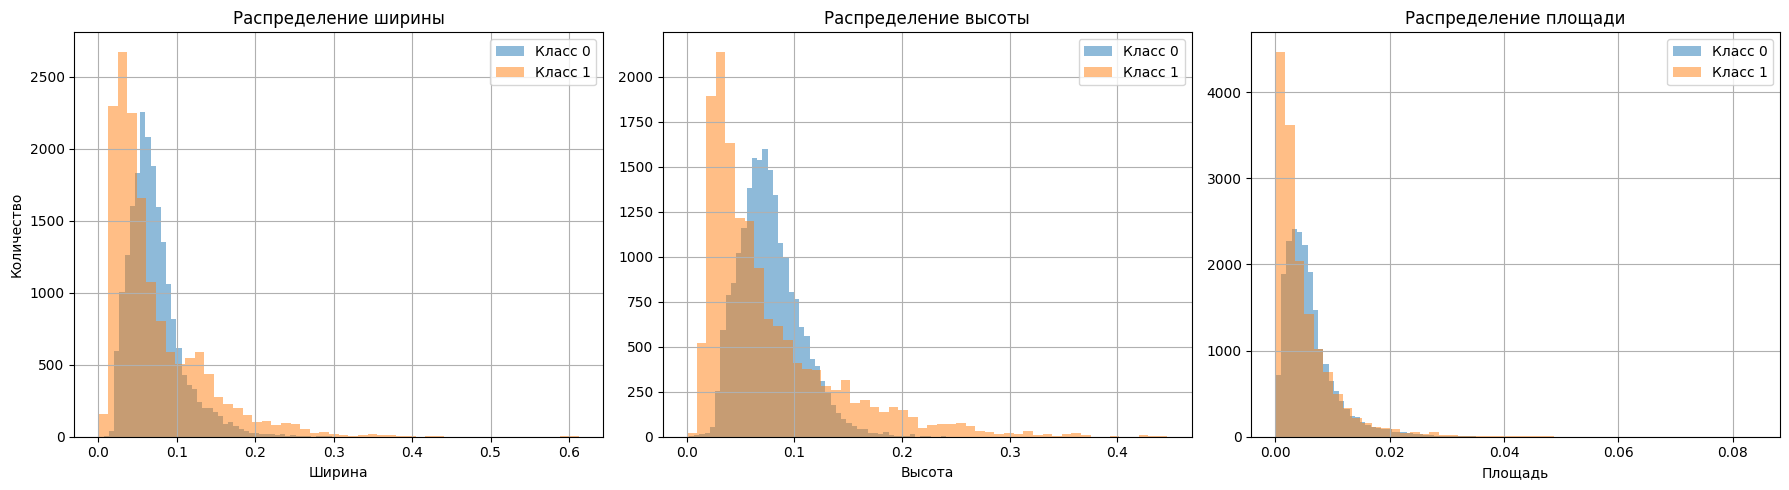

In [14]:
plot_box_distributions(train_lbl_dir)

# Обучение Yolo

In [15]:
# Загружаем предобученную yolo11n.pt
model = YOLO("../models/yolo11n.pt") 

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/ds_2/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xrplace_model_first6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

train: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/ds_2/train/labels... 2360 images, 28 backgrounds, 0 corrupt: 100%|██████████| 2360/2360 [00:00<00:00, 3307.03it/s]

train: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/ds_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 225.7±103.6 MB/s, size: 78.8 KB)



val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/ds_2/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]


Plotting labels to ../models/xrplace_model_first6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ../models/xrplace_model_first6
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45         0G      1.637      1.749      1.144        214        640: 100%|██████████| 295/295 [12:51<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]

                   all         56        990      0.801      0.741      0.819      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45         0G      1.432      1.022      1.051        249        640: 100%|██████████| 295/295 [13:10<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]

                   all         56        990      0.859      0.773      0.838      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45         0G       1.44     0.9685      1.059        151        640: 100%|██████████| 295/295 [19:13<00:00,  3.91s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

                   all         56        990      0.845      0.813      0.878       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45         0G      1.397     0.8898      1.046        220        640: 100%|██████████| 295/295 [20:10<00:00,  4.10s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

                   all         56        990      0.898      0.834      0.904      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45         0G      1.376      0.844       1.04        384        640: 100%|██████████| 295/295 [12:57<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.23s/it]

                   all         56        990      0.895       0.86      0.908      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45         0G      1.323     0.7852      1.018        367        640: 100%|██████████| 295/295 [50:39<00:00, 10.30s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.52s/it]

                   all         56        990      0.908      0.852      0.898      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45         0G      1.302     0.7674      1.016        163        640: 100%|██████████| 295/295 [27:46<00:00,  5.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]

                   all         56        990      0.908      0.863      0.909      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45         0G       1.31     0.7498      1.015        266        640: 100%|██████████| 295/295 [12:06<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]

                   all         56        990      0.931      0.853      0.912      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45         0G      1.297     0.7273      1.013        191        640: 100%|██████████| 295/295 [15:30<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

                   all         56        990      0.913      0.865      0.914      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45         0G      1.269     0.7181      1.003        217        640: 100%|██████████| 295/295 [26:00<00:00,  5.29s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]

                   all         56        990      0.907      0.866      0.915       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45         0G      1.263     0.7083      1.001        195        640: 100%|██████████| 295/295 [49:51<00:00, 10.14s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

                   all         56        990      0.927      0.878      0.929      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/45         0G      1.252     0.6854     0.9964        208        640: 100%|██████████| 295/295 [22:53<00:00,  4.66s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]

                   all         56        990      0.919      0.864      0.918      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/45         0G      1.236     0.6801     0.9958        170        640: 100%|██████████| 295/295 [21:17<00:00,  4.33s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

                   all         56        990       0.93      0.853      0.913       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/45         0G      1.227     0.6661     0.9881        241        640: 100%|██████████| 295/295 [18:34<00:00,  3.78s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]

                   all         56        990        0.9      0.881      0.918      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/45         0G       1.24     0.6712     0.9968        121        640:  83%|████████▎ | 245/295 [8:33:44<1:44:50, 125.81s/it] 


KeyboardInterrupt: 

In [8]:
metrics = model.val()

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 465.3±578.8 MB/s, size: 26.4 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/ds_2/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


                   all         56        990      0.913      0.847      0.913      0.574
                  door         56        527      0.955      0.937      0.962      0.681
                window         56        463      0.871      0.756      0.864      0.468
Speed: 1.0ms preprocess, 58.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to ../models/xrplace_model_first52


In [ ]:
# Загружаем лучшую модель после обучения
model = YOLO("runs/detect/xrplace_yolo/weights/best.pt")

# Выбираем тестовое изображение
test_image = "../data/Floor-Plan.v1i.yolov11/valid/images/sample.jpg"

# Предсказание
results = model(test_image)

# Визуализация
results[0].show()

# Сохранить изображение с предсказаниями
results[0].save(filename="prediction.jpg")


floorPlans.v1i.yolov11

In [ ]:
# ✅ Этап 5: Постпроцессинг предсказаний
results = model("PATH/TO/TEST_IMAGE.jpg")
results[0].plot()

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    print("Boxes:", boxes)
    print("Classes:", classes)


In [ ]:
# ✅ Этап 6 (опционально): Классификация назначения помещения
# Здесь может быть реализована отдельная модель


In [ ]:
# ✅ Этап 7: Тестирование на данных заказчика
test_image_path = "PATH/TO/CLIENT_IMAGE.png"
results = model(test_image_path)
results[0].save(filename="prediction.jpg")


In [ ]:
# ✅ Этап 8: Gradio приложение
import gradio as gr

def detect_doors_windows(image):
    results = model(image)
    annotated = results[0].plot()
    return Image.fromarray(annotated)

demo = gr.Interface(
    fn=detect_doors_windows,
    inputs=gr.Image(type="filepath"),
    outputs=gr.Image(type="pil"),
    title="XRPlace: Распознавание окон и дверей",
    description="Модель определяет окна и двери на плане помещения",
)
demo.launch()


In [ ]:
# ✅ Этап 9: Метрики оценки
metrics = model.val()
print(metrics)


In [ ]:
# ✅ Этап 10: Анализ ошибок
# Пример визуализации false positives / false negatives

def analyze_errors(results, conf_thresh=0.5):
    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        confs = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()
        for box, conf, cls in zip(boxes, confs, classes):
            if conf < conf_thresh:
                print(f"False positive (низкая уверенность): Класс {cls}, conf={conf:.2f}, box={box}")
        # Дополнительно: сравнение с ground truth для выявления пропущенных объектов

analyze_errors(results)


## ✅ Финальный вывод
- Модель определяет координаты дверей и окон
- Потенциально классифицирует тип помещения
- Есть Gradio-демо
- Метрики (IoU/mAP) позволяют объективно сравнивать модели
- Анализ ошибок помогает улучшать предсказания
